HW 03, DataX 

Marie Parent

# Part 1: Regularization [60 pts]

In [1]:
# load packages
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

# load Python DIGITS dataset
# DIGITS is a set of 1797 8x8 images.  
# Each image thus has 8*8=64 features, i.e., one value for each pixel.
digits = load_digits()

# split DIGITS into training and test (validation) sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.20, random_state=0)

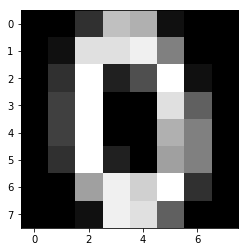

In [2]:
# randomly view one of the 1797 images
plt.imshow(np.reshape(x_train[random.randint(0,1796)], (8,8)), cmap=plt.cm.gray)

### 1. L2 Regularization
Use L2 regularization, i.e set 'penalty' coefficient equal to "l2" and tune regularisation coefficient, i.e  hyperparameter 'C', plot a graph between C values and validation accuracy.

In [3]:
from sklearn.linear_model import LogisticRegressionCV
L2model = LogisticRegressionCV(Cs=2, cv=3, penalty='l2') # instantiate
L2model.fit(x_train, y_train)

LogisticRegressionCV(Cs=2, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [4]:
Cs_values = [2, 4, 8, 16, 32, 64]
L2rss = []
for c in range(len(Cs_values)):
    L2model = LogisticRegressionCV(Cs=Cs_values[c], cv=3, penalty='l2') # instantiate
    L2model.fit(x_train, y_train)
    L2_predict = L2model.predict(x_test)
    L2rss += [sum((L2_predict-y_test)**2)]
L2rss

[697, 400, 325, 323, 266, 270]

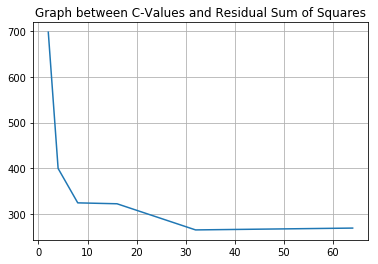

In [5]:
plt.title('Graph between C-Values and Residual Sum of Squares')
plt.grid()
plt.plot(Cs_values,L2rss)

### 2. L1 Regularization
Use L1 regularisation, i.e set 'penalty' coefficient equal to "l1" and tune regularisation coefficient, i.e  hyperparameter 'C', plot a graph between C values and validation accuracy.

In [6]:
from sklearn.linear_model import LogisticRegressionCV
L2model = LogisticRegressionCV(Cs=9, cv=3, penalty='l2') # instantiate
L2model.fit(x_train, y_train)

print('Training Accuracy:', L2model.score(x_train, y_train))

# validation accuracy
L2_predict = L2model.predict(x_test)
L2rss = sum((L2_predict-y_test)**2)
print('Validation Accuracy:', L2model.score(x_test, y_test))

Training Accuracy: 0.9916492693110647
Validation Accuracy: 0.9638888888888889


# Part 2: Neural Networks [140 pts]

# Part 2.1
# Softmax Model (Multiclass Logistic Regression)
### Model Blueprint

In [7]:
# Ensure Python2 and Python3 compatability
from __future__ import division, print_function, unicode_literals

# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# load and prepare data
from sklearn.datasets import load_digits
digits = load_digits()

# split DIGITS into training (80%) and test (20%) sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.20, random_state=0)

In [9]:
# understand data
print('Shape of feature matrix (training data):', x_train.shape)
print('Shape of target matrix (training data):', y_train.shape)
print('Shape of feature matrix (test data):', x_test.shape)
print('Shape of target matrix (test data):', y_test.shape)

Shape of feature matrix (training data): (1437, 64)
Shape of target matrix (training data): (1437,)
Shape of feature matrix (test data): (360, 64)
Shape of target matrix (test data): (360,)


We need to convert our target matrices to one-hot encoding.  Because the softmax model works by creating a vector of probabilities that a given observation is of each class, our target matrix must match this so that we can compute a cost function.

In [10]:
# Convert target matrices to one-hot encoding using pandas (dummy variables)
y_train_hot, y_test_hot = pd.get_dummies(y_train).values, pd.get_dummies(y_test).values
print('Shape of target matrix (training data):', y_train_hot.shape)
print('Shape of target matrix (test data):', y_test_hot.shape)
print('We can see that one hot coding has been correctly implemented by a quick comparison.')
print('Original: \n', y_train[:5])
print('One-Hot Encoded: \n', y_train_hot[:5])

Shape of target matrix (training data): (1437, 10)
Shape of target matrix (test data): (360, 10)
We can see that one hot coding has been correctly implemented by a quick comparison.
Original: 
 [6 5 3 4 4]
One-Hot Encoded: 
 [[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


In [11]:
# User Input
# Set parameters
batch_size    = 100                   # batch size
num_steps     = 200                   # number of epochs
learning_rate = 0.001                 # learning rate (alpha)

# Input data
train_dataset = x_train
train_labels  = y_train_hot    # labels should be one-hot encoded 
test_dataset  = x_test
test_labels   = y_test_hot     # labels should be one-hot encoded 

In [12]:
# Tensorboard setup
from datetime import datetime
import os      # the os module allows you to use operating system-dependent functionalities.
import pathlib # "an “Object-oriented filesystem paths” module which combines the best of Python's 
                       # file system modules like os, os.path, and glob to name a few.  
                       # This simplifies the number of modules you'll have to import to work with files ..."

t = datetime.utcnow().strftime("%Y%m%d%H%M%S") 
log_dir = "tf_logs"
logd = "/tmp/{}/r{}/".format(log_dir, t)

# Then every time you have specified a graph run:
# file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Make directory if it doesn't exist

from pathlib import Path
home = str(Path.home())

logdir = os.path.join(os.sep,home,logd)

if not os.path.exists(logdir):
    os.makedirs(logdir)
    
# TensorBoard Graph visualizer in notebook
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [13]:
# load Tensorflow
# Hides warnings
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.reset_default_graph()

In [14]:
# Generate input variables
num_features  = x_train.shape[1]      # number of features
num_labels    = y_train_hot.shape[1]  # number of classes

# Generate weight & bias variables
weight = tf.Variable(tf.zeros([num_features, num_labels])) # number of weights: 1 per feature per class
bias   = tf.Variable(tf.zeros([num_labels]))                          # number of bias terms: 1 per class

# Create output data placeholder
train_accuracy = []
test_accuracy = []

# Convert Input into TensorFlow constant
tf_test_dataset = tf.constant(test_dataset, dtype=tf.float32)

# Make input data placeholders
X = tf.placeholder(tf.float32, shape=(None, num_features)) # can feed any number of observations with 64 features each
Y = tf.placeholder(tf.float32, shape=(None, num_labels))   # labels are any number of observations with 10 possible classes each

# Make output data placeholder
pred_Y = tf.nn.softmax(tf.matmul(X, weight) + bias) # predicted labels

# Define cost function (aka loss function)
cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(pred_Y), axis=1))
# cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.constant(np.arange(0,num_labels)), logits=pred_Y)) # MARIE not sure
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# Predictions for Training & Test Sets
train_prediction = tf.nn.softmax(pred_Y)
test_prediction  = tf.nn.softmax(tf.matmul(tf_test_dataset, weight) + bias)

In [15]:
# Utility Functions
def get_next_batch(size, dataset, labels):
    '''Function to get the next batch of data.'''
    idx = np.arange(0, len(dataset))
    np.random.shuffle(idx)
    idx = idx[:size]
    data_shuffle = [dataset[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

# Function to get accuracy of predictions
def get_accuracy(x_temp, y_temp):
    '''Function to get the accuracy of the predictions.'''
    correctly_predicted = tf.equal(tf.argmax(Y,1), tf.argmax(pred_Y,1))
    accuracy = tf.reduce_mean(tf.cast(correctly_predicted, tf.float32))
    return sess.run(accuracy, feed_dict={X: x_temp, Y: y_temp})

### Model Training

In [16]:
## Execute the Blueprint
# Initialize Session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

print('Training...')
for i in range(num_steps):
    batch_train_dataset, batch_train_labels = get_next_batch(batch_size, train_dataset, train_labels)
    batch_test_dataset,  batch_test_labels  = get_next_batch(batch_size, test_dataset,  test_labels)
    sess.run(optimizer, feed_dict={X: batch_train_dataset, Y: batch_train_labels})
    sess.run(optimizer, feed_dict={X: batch_test_dataset,  Y: batch_test_labels})
    if i % 10 == 0:
        print('Current Test Accuracy: ', get_accuracy(test_dataset, test_labels))
    train_accuracy += [get_accuracy(train_dataset, train_labels)]
    test_accuracy  += [get_accuracy(test_dataset,  test_labels)]
print('...Done!')

Training...
Current Test Accuracy:  0.5388889
Current Test Accuracy:  0.87222224
Current Test Accuracy:  0.9222222
Current Test Accuracy:  0.91944444
Current Test Accuracy:  0.9388889
Current Test Accuracy:  0.9305556
Current Test Accuracy:  0.9361111
Current Test Accuracy:  0.9388889
Current Test Accuracy:  0.9361111
Current Test Accuracy:  0.9388889
Current Test Accuracy:  0.95
Current Test Accuracy:  0.95
Current Test Accuracy:  0.94722223
Current Test Accuracy:  0.9583333
Current Test Accuracy:  0.9583333
Current Test Accuracy:  0.9611111
Current Test Accuracy:  0.9638889
Current Test Accuracy:  0.9638889
Current Test Accuracy:  0.96944445
Current Test Accuracy:  0.96666664
...Done!


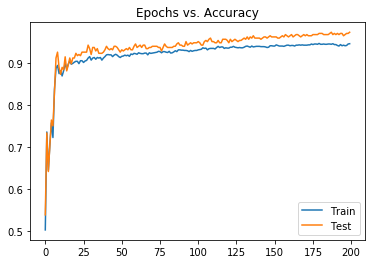

In [17]:
# Graph Results
plt.title('Epochs vs. Accuracy')
plt.plot(range(num_steps), train_accuracy, label='Train')
plt.plot(range(num_steps), test_accuracy, label='Test')
plt.legend()

In [18]:
print('Validation Accuracy:', test_accuracy[-1])

Validation Accuracy: 0.9722222


In [19]:
show_graph(tf.get_default_graph()) # MARIE this is no longer working for some reason =(

TypeError: '<stripped 92160 bytes>' has type str, but expected one of: bytes

# Part 2.2
# Vanilla Dense Neural Network
- Dense neural network:  all neurons in one layer are connected to all neurons in the adjacent layer(s)
- Convolutional neural network: not all are connected
- vanilla neural network: a NN that updates using vanilla (standard?) backpropogation after every training pattern.
    - same as vanilla RNN?
    - unlike some other models, doesn't learn long-term relationships between nodes?
    - aka "multilayer perceptron"

## Set Up
#### General notebook setup

In [20]:
# Pyton 2 and 3 support - Make notebook compatible with Python 2 and 3, plus import standard packages.
from __future__ import division, print_function, unicode_literals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [21]:
import tensorflow as tf

In [22]:
# Check tf version, oftentimes tensorflow is not backwards compatible
tf.__version__

'1.7.0'

In [23]:
tf.reset_default_graph()

#### TensorBoard setup

In [24]:
from datetime import datetime
import os
import pathlib

t = datetime.utcnow().strftime("%Y%m%d%H%M%S") 
log_dir = "tf_logs"
logd = "/tmp/{}/r{}/".format(log_dir, t)

# Then every time you have specified a graph run:
# file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Make directory if it doesn't exist

from pathlib import Path
home = str(Path.home())

logdir = os.path.join(os.sep,home,logd)

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [25]:
# TensorBoard Graph visualizer in notebook
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## CONSTRUCTION PHASE

### Data Prep

In [26]:
from sklearn.datasets import load_digits
digits = load_digits()

# split DIGITS into training, test, and validation sets
from sklearn.model_selection import train_test_split
# step 1: split into 80% training and test, 20% validation
digits_x_traintest, digits_x_validation, digits_y_traintest, digits_y_validation = train_test_split(digits.data, digits.target, test_size=0.20, random_state=0)
# step 2: split traintest to get 60% training, 20% test
digits_x_train, digits_x_test, digits_y_train, digits_y_test = train_test_split(digits_x_traintest, digits_y_traintest, test_size=0.25, random_state=0)
# step 3: delete unecessary intermediate variables
del digits_x_traintest, digits_y_traintest

In [27]:
# Assign data set parts to names
X_train = digits_x_train             # X arrays should contain type float32
X_test = digits_x_test
X_validation = digits_x_validation
y_train = digits_y_train             # y arrays should contain type int64
y_test = digits_y_test
y_validation = digits_y_validation

### Shell Construction

In [28]:
# Define hyperparameters and input size
n_inputs = 8*8  # Based on number of features in the user-selected data set
n_hidden1 = 300 # number of neurons in hidden layer 1
n_hidden2 = 200 # number of neurons in hidden layer 2
n_hidden3 = 100 # number of neurons in hidden layer 3
n_outputs = 10  # Based on number of classes

In [29]:
# Placeholders for data (inputs and targets)
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [30]:
# Define neuron layers (Tanh in hidden layers)
# We'll take care of Softmax for output with loss function

def neuron_layer(X, n_neurons, name, activation=None):
    # X input to neuron
    # number of neurons for the layer
    # name of layer
    # pass in eventual activation function
    
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        
        # initialize weights to prevent vanishing / exploding gradients
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # Initialize weights for the layer
        W = tf.Variable(init, name="weights")
        # biases
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        # Output from every neuron
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [31]:
prob_keep = tf.placeholder(tf.float32,name='prob_keep')

# Define the hidden layers
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X,       n_hidden1, name="hidden1", activation=tf.nn.tanh)
    drop1 = tf.nn.dropout(hidden1, prob_keep, name="drop1")
    hidden2 = neuron_layer(drop1, n_hidden2, name="hidden2", activation=tf.nn.tanh)
    drop2 = tf.nn.dropout(hidden2, prob_keep, name="drop2")
    hidden3 = neuron_layer(drop2, n_hidden3, name="hidden3", activation=tf.nn.tanh)
    drop3 = tf.nn.dropout(hidden3, prob_keep, name="drop3")
    logits  = neuron_layer(drop3, n_outputs, name="outputs")

In [32]:
# Define loss function (that also optimizes Softmax for output):
with tf.name_scope("loss"):
    # logits are from the last output of the dnn
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [33]:
# Training step with Gradient Descent
learning_rate = 0.001   # User Input

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [34]:
# Evaluation to see accuracy
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

## EVALUATION PHASE

### Training

In [35]:
# Utility functions
def get_batch(X_array, y_array, batch_size):
    '''Takes our entire training data.  Returns batch_size number of observations.'''
    y_array_reshaped = np.reshape(y_array, (y_array.shape[0], 1))
    array_to_sample = np.append(X_array, y_array_reshaped, 1)
    sample_indices = np.random.choice(a=X_array.shape[0], size=batch_size, replace=False)
    sample_batch = array_to_sample[sample_indices,:]
    X_batch = sample_batch[:,:X_array.shape[1]]
    y_batch = np.reshape(sample_batch[:,X_array.shape[1]:], (batch_size,))
    return X_batch, y_batch

In [36]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 1000     # User Input
batch_size = 100    # User Input
dropout_rate = 0.1  # User Input
train_acc_record = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):                               # for each gradient step (epoch)
        for iteration in range(y_train.shape[0] // batch_size): # for each batch 
            X_batch, y_batch = get_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, prob_keep: 1-dropout_rate})
        acc_train = accuracy.eval(feed_dict={X: X_batch,      y: y_batch,      prob_keep: 1}) 
        acc_val   = accuracy.eval(feed_dict={X: X_validation, y: y_validation, prob_keep: 1})
        train_acc_record += [acc_train]
        if epoch<11 or epoch%50==0:
            print("Step", epoch, "Training Accuracy:", acc_train, "Validation accuracy:", acc_val)
    save_path = saver.save(sess, "./my_model_final.ckpt") # save model

Step 0 Training Accuracy: 0.11 Validation accuracy: 0.108333334
Step 1 Training Accuracy: 0.11 Validation accuracy: 0.119444445
Step 2 Training Accuracy: 0.14 Validation accuracy: 0.12222222
Step 3 Training Accuracy: 0.11 Validation accuracy: 0.125
Step 4 Training Accuracy: 0.18 Validation accuracy: 0.125
Step 5 Training Accuracy: 0.16 Validation accuracy: 0.1388889
Step 6 Training Accuracy: 0.2 Validation accuracy: 0.17222223
Step 7 Training Accuracy: 0.23 Validation accuracy: 0.20277777
Step 8 Training Accuracy: 0.25 Validation accuracy: 0.22222222
Step 9 Training Accuracy: 0.26 Validation accuracy: 0.24444444
Step 10 Training Accuracy: 0.32 Validation accuracy: 0.26944444
Step 50 Training Accuracy: 0.87 Validation accuracy: 0.7638889
Step 100 Training Accuracy: 0.9 Validation accuracy: 0.8666667
Step 150 Training Accuracy: 0.94 Validation accuracy: 0.88055557
Step 200 Training Accuracy: 0.95 Validation accuracy: 0.9
Step 250 Training Accuracy: 0.95 Validation accuracy: 0.9166667
Ste

## Results

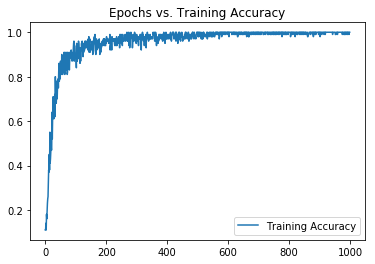

In [37]:
# Graph Results
plt.title('Epochs vs. Training Accuracy')
plt.plot(range(n_epochs), train_acc_record, label='Training Accuracy')
plt.legend()

In [38]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    Z = logits.eval(feed_dict={X: X_test, prob_keep: 1})
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test, prob_keep: 1})
y_pred = np.argmax(Z, axis=1)

print("Predicted classes:", y_pred[:20])
print("Actual classes:   ", y_test[:20])

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
Predicted classes: [0 4 0 7 2 2 3 9 2 2 1 0 3 4 2 3 4 7 1 5]
Actual classes:    [0 4 0 7 2 2 3 9 2 2 1 0 3 4 2 3 4 7 1 5]


In [39]:
print("Accuracy on Test Data         (final round of training):", acc_train)
print("Accuracy on Validation Data (final round of validation):", acc_val)
print("Accuracy on 20% Test Data:                            ", acc_test)

Accuracy on Test Data         (final round of training): 1.0
Accuracy on Validation Data (final round of validation): 0.95555556
Accuracy on 20% Test Data:                             0.94722223


In [40]:
show_graph(tf.get_default_graph())